In [31]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras
import pydub
import matplotlib.pyplot as plt

In [32]:
from keras import Sequential
from keras.layers import Dense

In [33]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


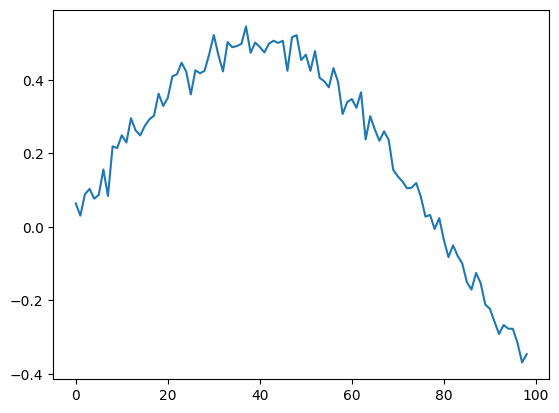

In [34]:
# Generate sine wave
def gen_sine(freq, sr, secs, noise_sd=False, amplitude=0.5):
    num = int(sr*secs)
    testing_np_version = np.zeros((num, 2))
    testing_np_version[:, 0] = np.sin(2 * np.pi * np.arange(num) * freq / sr) * amplitude
    testing_np_version[:, 1] = np.sin(2 * np.pi * np.arange(num) * freq / sr) * amplitude
    
    if noise_sd is not None:
        # Add noise
        testing_np_version[:, 0] += np.random.normal(0, noise_sd, size=num)
        testing_np_version[:, 1] += np.random.normal(0, noise_sd, size=num)

    return testing_np_version

secs = 5
sr = 48000
freq = 300
testing_np_version = gen_sine(freq, sr, secs, noise_sd=0.03)
plt.plot(testing_np_version[1:100, 0])
plt.show()

In [35]:
write("mp3_check.mp3",sr,testing_np_version,normalized=True)

In [47]:
# Randomly generate frequencies between C2 and C8
c2 = 65.41
c8 = 4186.01
c7 = 2093.00

# Generate N training samples
N = 100000
freqs = np.random.uniform(c2, c8, size=N)
noise_sds = np.random.exponential(0.02, size=N)
amplitudes = np.random.uniform(0.4, 1, size=N)
X_lst = []
for i in range(N):
    sine = gen_sine(freqs[i], sr=48000, secs=1/96, noise_sd=noise_sds[i], amplitude=amplitudes[i])[:, 0]
    X_lst.append(sine)

X = np.stack(X_lst)
y = freqs
split = 0.7
X_train = X[:int(split*len(X_lst))]
y_train = freqs[:int(split*len(X_lst))]
X_test = X[int(split*len(X_lst)):]
y_test = freqs[int(split*len(X_lst)):]
X_train.shape

(70000, 500)

In [48]:
# Build network
input_shape = len(X_lst[0])
 # create model
model = keras.Sequential()
model.add(Dense(input_shape, input_shape=(input_shape,), kernel_initializer='normal', activation='relu'))
model.add(Dense(input_shape, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Display a summary of the model architecture.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 500)               250500    
                                                                 


 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dense_11 (Dense)            (None, 1)                 501       
                                                                 
Total params: 501,501
Trainable params: 501,501
Non-trainable params: 0
_________________________________________________________________


In [49]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X, y, validation_split=0.2, batch_size=int(N*0.1), epochs=100, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 1s 127ms/step - loss: 5899516.0000 - val_loss: 5830566.0000
Epoch 2/100
8/8 [==============================] - 1s 99ms/step - loss: 5827524.5000 - val_loss: 5721352.0000
Epoch 3/100
8/8 [==============================] - 1s 98ms/step - loss: 5673400.5000 - val_loss: 5500871.5000
Epoch 4/100
8/8 [==============================] - 1s 98ms/step - loss: 5380704.5000 - val_loss: 5109420.5000
Epoch 5/100
8/8 [==============================] - 1s 97ms/step - loss: 4890486.5000 - val_loss: 4488050.5000
Epoch 6/100
8/8 [==============================] - 1s 95ms/step - loss: 4150407.2500 - val_loss: 3609737.7500
Epoch 7/100
8/8 [==============================] - 1s 97ms/step - loss: 3165693.2500 - val_loss: 2526764.7500
Epoch 8/100
8/8 [==============================] - 1s 95ms/step - loss: 2046360.3750 - val_loss: 1428025.5000
Epoch 9/100
8/8 [==============================] - 1s 101ms/step - loss: 1046155.7500 - val_loss: 631606.5625
Epoch 10/

In [50]:
model.predict(X_test[:2])

1/1 [==============================] - 0s 41ms/step


array([[2334.738   ],
       [  92.535034]], dtype=float32)

In [51]:
y_test[:2]

array([2408.12341437,  106.82799196])

In [41]:
model.predict(np.expand_dims(testing_np_version[:, 0], 0))

2023-12-04 00:37:57.201132: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [1,240000], In[1]: [500,500]
	 [[{{node sequential_1/dense_3/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_3/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/traitlets/config/application.py", line 1077, in launch_instance
      app.start()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/vc/ln24mj4d0lg9gk8v28ym54jc0000gn/T/ipykernel_93390/3321221702.py", line 1, in <module>
      model.predict(np.expand_dims(testing_np_version[:, 0], 0))
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/Users/anandkrishnakumar/miniconda3/envs/musicr/lib/python3.11/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_3/Relu'
Matrix size-incompatible: In[0]: [1,240000], In[1]: [500,500]
	 [[{{node sequential_1/dense_3/Relu}}]] [Op:__inference_predict_function_5034]

In [52]:
model.save("../models/note_detect.h5", save_format="h5")

In [22]:
from tensorflow.keras.models import load_model
model_eval = load_model('../models/note_detect.h5', compile=False)

In [23]:
model_eval.predict(np.expand_dims(testing_np_version[:, 0], 0))

1/1 [==============================] - 0s 32ms/step


array([[630.546]], dtype=float32)

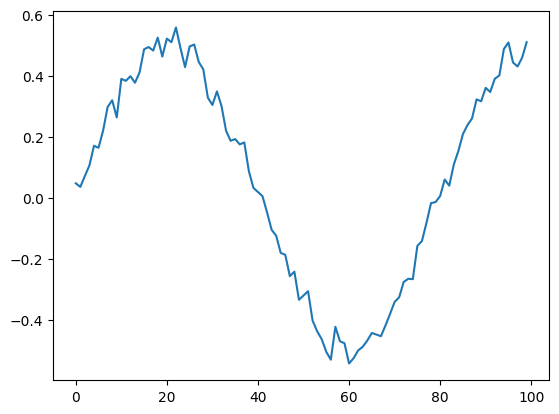

In [24]:
plt.plot(testing_np_version[:100, 0])